In [14]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

%pip install ahrs
from ahrs.filters.madgwick import Madgwick
from ahrs.filters.mahony import Mahony
from ahrs.filters import EKF
from ahrs.common.orientation import acc2q

file_path = '/home/asp/Downloads/AML/final-project/a000_1/data.hdf5'

Note: you may need to restart the kernel to use updated packages.


CONTENTS OF HDF5 FILE:
pose
	 ekf_ori
		 
	 tango_ori
		 
	 tango_pos
		 
raw
	 imu
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, wifi_address, wifi_values
	 tango
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, tango_adf_pose, tango_pose, wifi_address, wifi_values
synced
	 acce
		 
	 game_rv
		 
	 grav
		 
	 gyro
		 
	 gyro_uncalib
		 
	 linacce
		 
	 magnet
		 
	 rv
		 
	 time
		 
pose data
(10000, 4)
(10000, 4)
raw data
(10000, 4)
(10000, 4)
(10000, 4)
(10000, 5)
(10000, 5)
time step:
0.005000000001018634


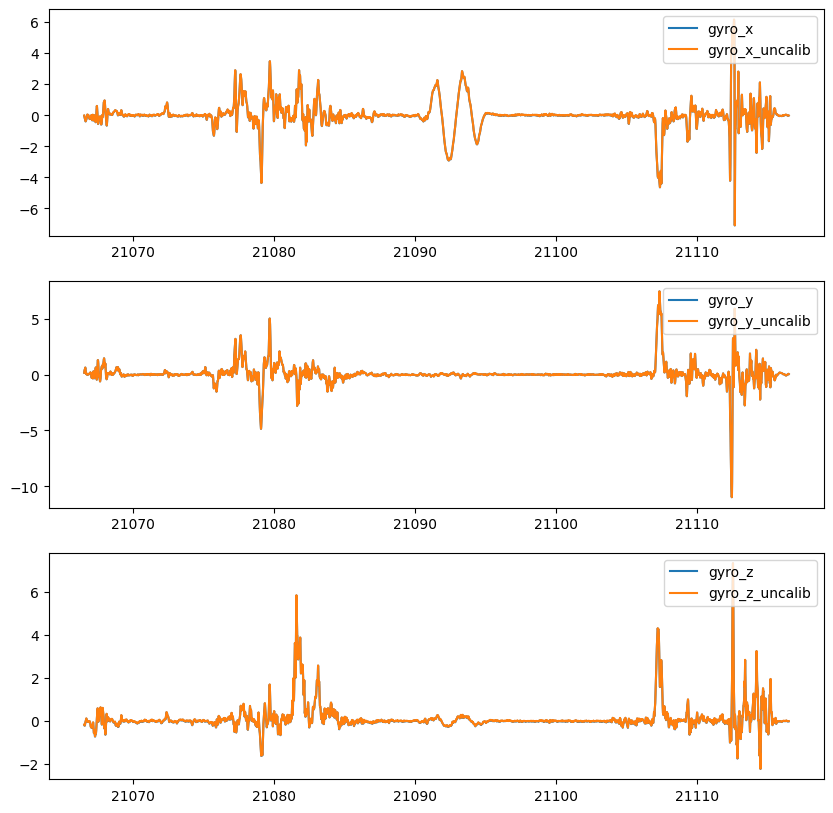

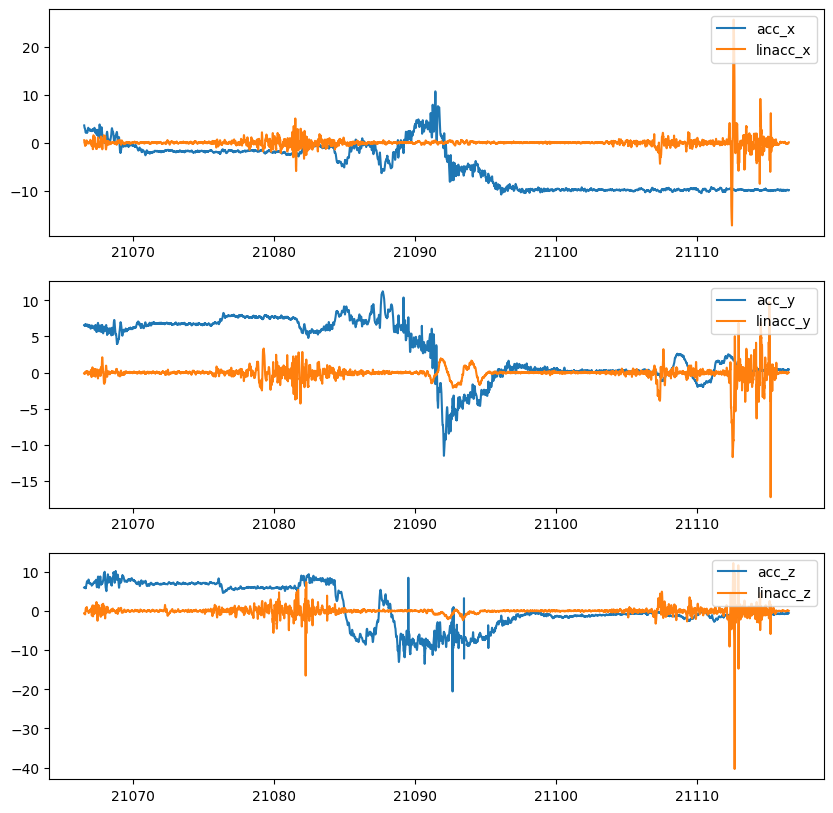

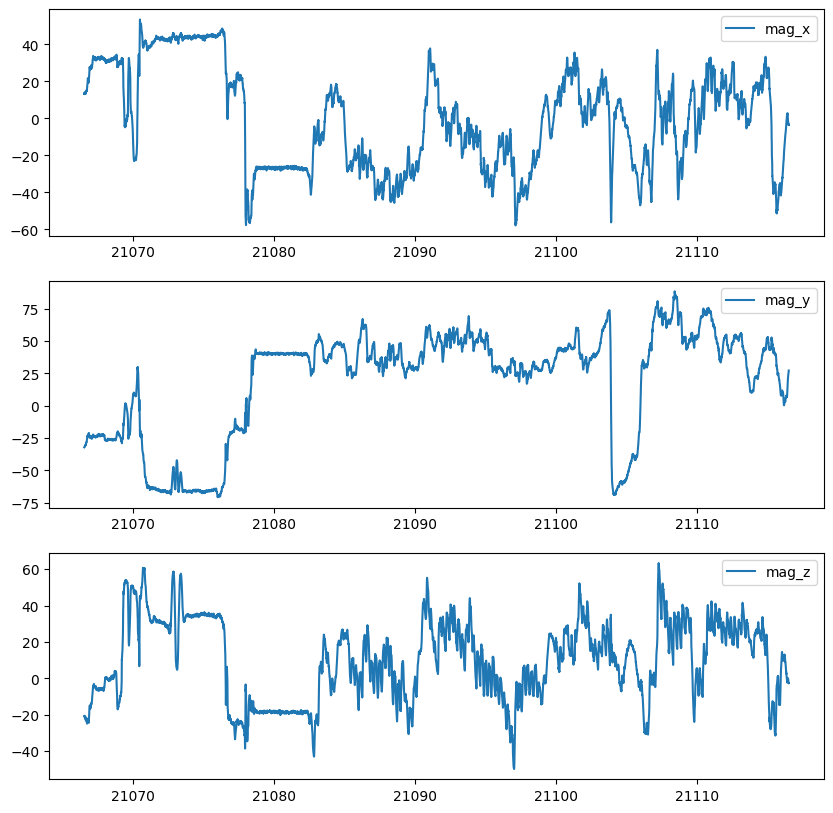

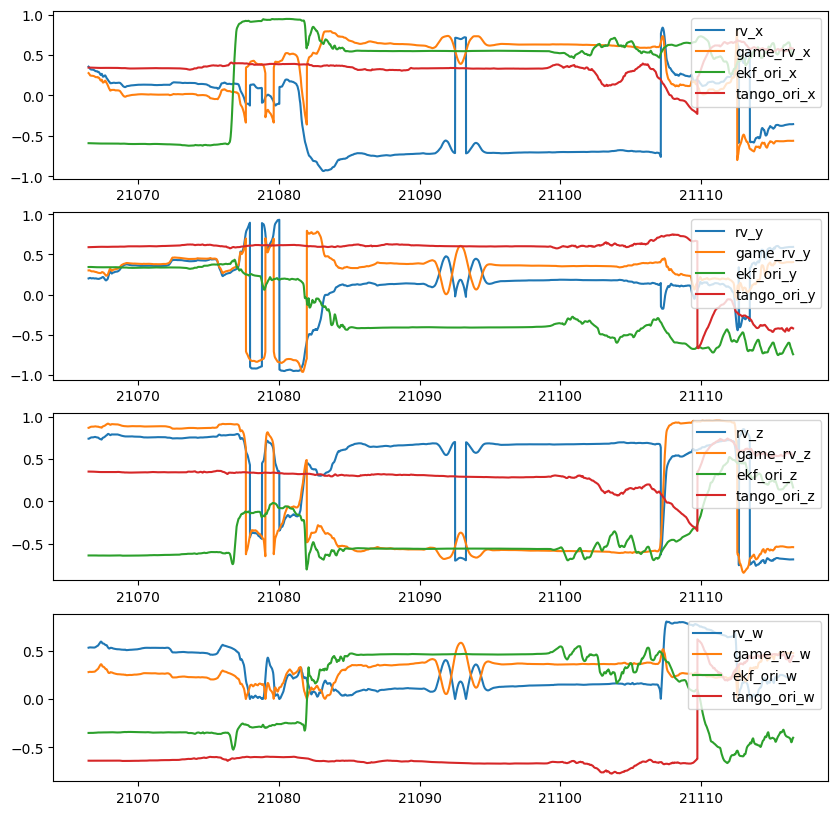

In [15]:
if '..' not in sys.path:
    sys.path.append('../')
from utils import load_data
data_dict = load_data(file_path, verbose=True)

N = 10000

if N == 0:
    ekf_ori = data_dict['pose/ekf_ori']
    tango_ori = data_dict['pose/tango_ori']
    gyro = data_dict['raw/imu/gyro']
    gyro_uncalib = data_dict['raw/imu/gyro_uncalib']
    acc = data_dict['raw/imu/acce']
    linacc = data_dict['raw/imu/linacce']
    mag = data_dict['raw/imu/magnet']
    num_samples = ekf_ori.shape[0]
    time = data_dict['synced/time']
    rv = data_dict['raw/imu/rv']
    game_rv = data_dict['raw/imu/game_rv']
    diffs = np.diff(time)
    dt = np.mean(diffs)
    q_0 = ekf_ori[0,:]
    
else:
    ekf_ori = data_dict['pose/ekf_ori'][:N]
    tango_ori = data_dict['pose/tango_ori'][:N]
    gyro = data_dict['raw/imu/gyro'][:N]
    gyro_uncalib = data_dict['raw/imu/gyro_uncalib'][:N]
    acc = data_dict['raw/imu/acce'][:N]
    linacc = data_dict['raw/imu/linacce'][:N]
    mag = data_dict['raw/imu/magnet'][:N]
    num_samples = ekf_ori.shape[0]
    time = data_dict['synced/time'][:N]
    rv = data_dict['raw/imu/rv'][:N]
    game_rv = data_dict['raw/imu/game_rv'][:N]
    diffs = np.diff(time)
    dt = np.mean(diffs)
    q_0 = ekf_ori[0,:]

print('pose data')
print(ekf_ori.shape)
print(tango_ori.shape)
print('raw data')
print(gyro.shape)
print(acc.shape)
print(mag.shape)
print(game_rv.shape)
print(rv.shape)
print('time step:')
print(dt)

fig, ax = plt.subplots(3,1, figsize=(10,10))
ax[0].plot(time, gyro[:,1], label='gyro_x')
ax[0].plot(time, gyro_uncalib[:,1], label='gyro_x_uncalib')
ax[0].legend(loc = 'upper right')
ax[1].plot(time, gyro[:,2], label='gyro_y')
ax[1].plot(time, gyro_uncalib[:,2], label='gyro_y_uncalib')
ax[1].legend(loc = 'upper right')
ax[2].plot(time, gyro[:,3], label='gyro_z')
ax[2].plot(time, gyro_uncalib[:,3], label='gyro_z_uncalib')
ax[2].legend(loc = 'upper right')
plt.show()


fig, ax = plt.subplots(3,1, figsize=(10,10))
ax[0].plot(time, acc[:,1], label='acc_x')
ax[0].plot(time, linacc[:,1], label='linacc_x')
ax[0].legend(loc = 'upper right')
ax[1].plot(time, acc[:,2], label='acc_y')
ax[1].plot(time, linacc[:,2], label='linacc_y')
ax[1].legend(loc = 'upper right')
ax[2].plot(time, acc[:,3], label='acc_z')
ax[2].plot(time, linacc[:,3], label='linacc_z')
ax[2].legend(loc = 'upper right')
plt.show()

fig, ax = plt.subplots(3,1, figsize=(10,10))
ax[0].plot(time, mag[:,1], label='mag_x')
ax[0].legend()
ax[1].plot(time, mag[:,2], label='mag_y')
ax[1].legend()
ax[2].plot(time, mag[:,3], label='mag_z')
ax[2].legend(loc = 'upper right')
plt.show()

fig, ax = plt.subplots(4,1, figsize=(10,10))
ax[0].plot(time, rv[:,1], label='rv_x')
ax[0].plot(time, game_rv[:,1], label='game_rv_x')
ax[0].plot(time, ekf_ori[:,0], label='ekf_ori_x')
ax[0].plot(time, tango_ori[:,0], label='tango_ori_x')
ax[0].legend(loc = 'upper right')
ax[1].plot(time, rv[:,2], label='rv_y')
ax[1].plot(time, game_rv[:,2], label='game_rv_y')
ax[1].plot(time, ekf_ori[:,1], label='ekf_ori_y')
ax[1].plot(time, tango_ori[:,1], label='tango_ori_y')
ax[1].legend(loc = 'upper right')
ax[2].plot(time, rv[:,3], label='rv_z')
ax[2].plot(time, game_rv[:,3], label='game_rv_z')
ax[2].plot(time, ekf_ori[:,2], label='ekf_ori_z')
ax[2].plot(time, tango_ori[:,2], label='tango_ori_z')
ax[2].legend(loc = 'upper right')
ax[3].plot(time, rv[:,4], label='rv_w')
ax[3].plot(time, game_rv[:,4], label='game_rv_w')
ax[3].plot(time, ekf_ori[:,3], label='ekf_ori_w')
ax[3].plot(time, tango_ori[:,3], label='tango_ori_w')
ax[3].legend(loc = 'upper right')
plt.show()

## Find Ideal Parameters

In [16]:
def madgwick_cost(params):
    gain = params[0]
    madgwick_filter = Madgwick(gyr = gyro[:,1:], acc = acc[:,1:], mag=mag[:,1:], dt = dt, q0 = q_0, 
                               gain = gain)
    Q_1 = madgwick_filter.Q
    return np.mean(np.linalg.norm(Q_1 - tango_ori, axis = 1)**2)

def mahony_cost(params):
    k_P, k_I = params
    mahony_filter = Mahony(gyr = gyro[:,1:], acc = acc[:,1:], mag=mag[:,1:], dt = dt, q0 = q_0,
                           k_P = k_P, k_I = k_I)
    Q_2 = mahony_filter.Q
    return np.mean(np.linalg.norm(Q_2 - tango_ori, axis = 1)**2)

def ekf_cost(params):
    gyro_var, acc_var, mag_var = params**2
    ekf = EKF(gyr = gyro[:,1:], acc = acc[:,1:], mag=mag[:,1:], dt = dt, q0=q_0, 
              gyro_var = gyro_var, acc_var = acc_var, mag_var=mag_var)
    Q_ekf = ekf.Q
    return np.mean(np.linalg.norm(Q_ekf - tango_ori, axis = 1)**2)

# Initial guess
init_guess_madgwick = [0.033]
init_guess_mahony = [1.0, 0.3]
init_guess_ekf = [0.3, 0.5, 0.8]
bounds_ekf = [(0, None), (0, None), (0, None)]

# Optimization for Madgwick
madgwick_result = minimize(madgwick_cost, init_guess_madgwick, tol=1e-4, method='Nelder-Mead')
optimal_gain = madgwick_result.x
print("Optimized Gain for Madgwick Filter: ", optimal_gain)

# Optimization for Mahony
mahony_result = minimize(mahony_cost, init_guess_mahony, tol=1e-4, method='Nelder-Mead')
optimal_k_P, optimal_k_I = mahony_result.x
print("Optimized k_P and k_I for Mahony Filter: ", optimal_k_P, optimal_k_I)

# # Optimization for EKF
# ekf_result = minimize(ekf_cost, init_guess_ekf, bounds=bounds_ekf, tol=1e-4)
# optimal_gyro_var, optimal_acc_var, optimal_mag_var = ekf_result.x
# print("Optimized gyro_var and acc_var for EKF: ", optimal_gyro_var, optimal_acc_var, optimal_mag_var)

Optimized Gain for Madgwick Filter:  [0.01582969]
Optimized k_P and k_I for Mahony Filter:  0.9027838354007202 0.31989864102154086


In [19]:
# Optimized Gain for Madgwick Filter:  [0.01582969]
# Optimized k_P and k_I for Mahony Filter:  0.9027838354007202 0.31989864102154086
# Optimized gyro_var and acc_var for EKF:  0.3 0.5 0.8


gain = 0.01582969
madgwick_filter = Madgwick(gyr = gyro[:,1:], acc = acc[:,1:], mag=mag[:,1:], dt = dt, q0=q_0, gain=gain)
Q_1 = madgwick_filter.Q


k_P = 0.9027838354007202
k_I = 0.31989864102154086
mahony_filter = Mahony(gyr = gyro[:,1:], acc = acc[:,1:], mag=mag[:,1:], dt = dt, q0=q_0, k_P=k_P, k_I=k_I)
Q_2 = mahony_filter.Q


acc_var = 0.3**2
gyro_var = 0.5**2
mag_var = 0.8**2
ekf = EKF(gyr=gyro[:,1:], acc=acc[:,1:], mag=mag[:,1:], dt = dt, q0=q_0, noises= [gyro_var, acc_var, mag_var])
Q_ekf = ekf.Q

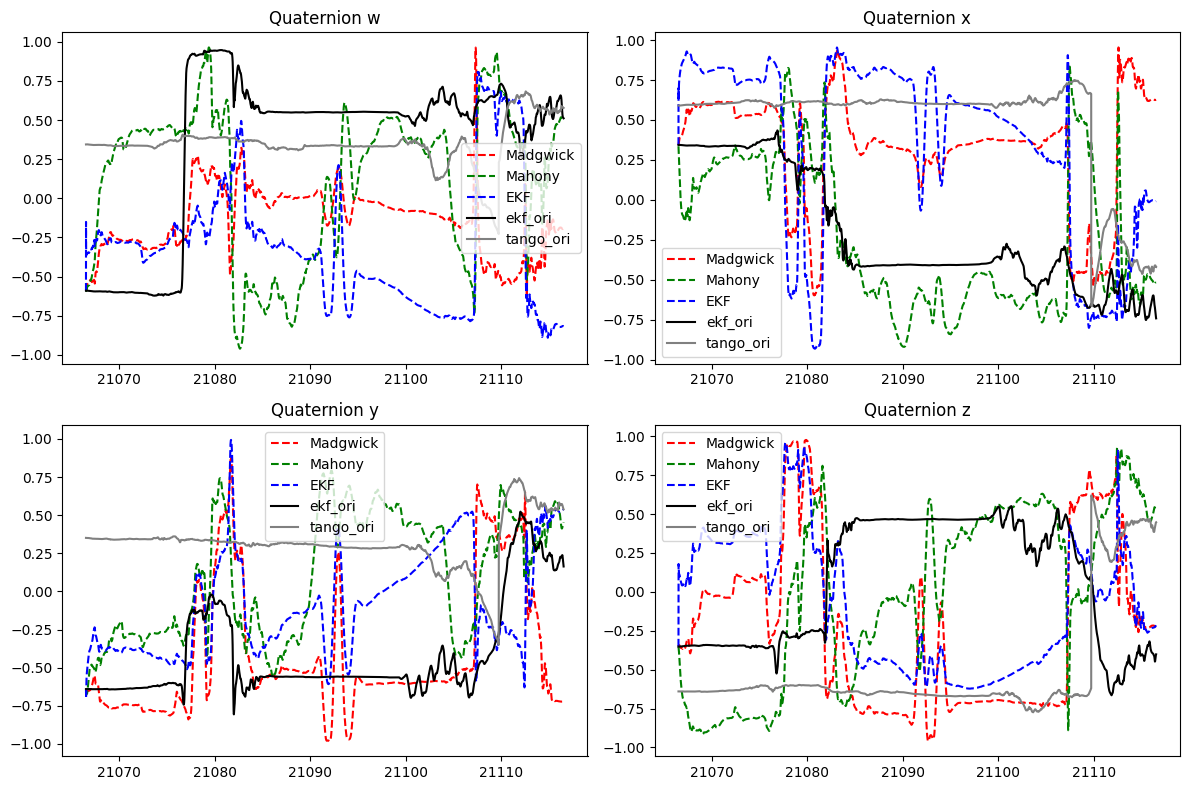

In [20]:
end = time[-1]
start = time[0]
t = np.linspace(start, end+dt, num_samples)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Quaternion w
axs[0, 0].plot(t, Q_1[:, 0], label='Madgwick', color='red', linestyle='dashed')
axs[0, 0].plot(t, Q_2[:, 0], label='Mahony', color='green', linestyle='dashed')
axs[0, 0].plot(t, Q_ekf[:, 0], label='EKF', color='blue', linestyle='dashed')
axs[0, 0].plot(t, ekf_ori[:, 0], label='ekf_ori', color='black')
axs[0, 0].plot(t, tango_ori[:, 0], label='tango_ori', color='gray')
axs[0, 0].set_title('Quaternion w')
axs[0, 0].legend()

# Quaternion x
axs[0, 1].plot(t, Q_1[:, 1], label='Madgwick', color='red', linestyle='dashed')
axs[0, 1].plot(t, Q_2[:, 1], label='Mahony', color='green', linestyle='dashed')
axs[0, 1].plot(t, Q_ekf[:, 1], label='EKF', color='blue', linestyle='dashed')
axs[0, 1].plot(t, ekf_ori[:, 1], label='ekf_ori', color='black')
axs[0, 1].plot(t, tango_ori[:, 1], label='tango_ori', color='gray')
axs[0, 1].set_title('Quaternion x')
axs[0, 1].legend()

# Quaternion y
axs[1, 0].plot(t, Q_1[:, 2], label='Madgwick', color='red', linestyle='dashed')
axs[1, 0].plot(t, Q_2[:, 2], label='Mahony', color='green', linestyle='dashed')
axs[1, 0].plot(t, Q_ekf[:, 2], label='EKF', color='blue', linestyle='dashed')
axs[1, 0].plot(t, ekf_ori[:, 2], label='ekf_ori', color='black')
axs[1, 0].plot(t, tango_ori[:, 2], label='tango_ori', color='gray')
axs[1, 0].set_title('Quaternion y')
axs[1, 0].legend()

# Quaternion z
axs[1, 1].plot(t, Q_1[:, 3], label='Madgwick', color='red', linestyle='dashed')
axs[1, 1].plot(t, Q_2[:, 3], label='Mahony', color='green', linestyle='dashed')
axs[1, 1].plot(t, Q_ekf[:, 3], label='EKF', color='blue', linestyle='dashed')
axs[1, 1].plot(t, ekf_ori[:, 3], label='ekf_ori', color='black')
axs[1, 1].plot(t, tango_ori[:, 3], label='tango_ori', color='gray')
axs[1, 1].set_title('Quaternion z')
axs[1, 1].legend()

# Display the plot
plt.tight_layout()
plt.show()
